In [2]:
import os
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# 数据集路径
dataset_dir = r'C:\Users\zhou\Desktop\dataset'
train_dir = os.path.join(dataset_dir, 'train(augmented)')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

# 标签文件路径
train_labels_path = r'C:\Users\zhou\Desktop\dataset\train.csv'
val_labels_path = r'C:\Users\zhou\Desktop\dataset\val.csv'
test_labels_path = r'C:\Users\zhou\Desktop\dataset\test.csv'

# 加载标签并更新路径
train_df = pd.read_csv(train_labels_path)
train_df['path'] = train_df['path'].apply(lambda x: os.path.join(train_dir, x))

val_df = pd.read_csv(val_labels_path)
val_df['path'] = val_df['path'].apply(lambda x: os.path.join(val_dir, x))

test_df = pd.read_csv(test_labels_path)
test_df['path'] = test_df['path'].apply(lambda x: os.path.join(test_dir, x))

# 模型保存路径
save_model_dir = r'C:\Users\zhou\Desktop\dataset\model'

# 定义超参数
batch_size = 64
epochs = 5
img_size = (224, 224)

# 数据生成器
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

# 定义ShuffleNet模型
def shufflenet_model():
    def shuffle_unit(x, out_channels, strides=1):
        # ShuffleNet Unit
        in_channels = x.shape[-1]
        
        # Pointwise group convolution (1x1 convolution)
        x = layers.Conv2D(out_channels, (1, 1), strides=strides, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        # Depthwise convolution (3x3 convolution)
        x = layers.DepthwiseConv2D((3, 3), strides=strides, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        # Pointwise group convolution (1x1 convolution)
        x = layers.Conv2D(out_channels, (1, 1), strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        
        return x
    
    # ShuffleNet Architecture
    input_layer = layers.Input(shape=(224, 224, 3))
    
    # Initial convolution
    x = layers.Conv2D(24, (3, 3), strides=2, padding='same', use_bias=False)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # First ShuffleNet unit
    x = shuffle_unit(x, 24)
    
    # Additional ShuffleNet units
    x = shuffle_unit(x, 48, strides=2)
    x = shuffle_unit(x, 48)
    
    # Transition layer (downsampling)
    x = shuffle_unit(x, 96, strides=2)
    
    # Fully connected layers with L2 regularization
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(4096, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 Regularization
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 Regularization
    x = layers.Dropout(0.5)(x)
    
    # Output layer (softmax)
    output_layer = layers.Dense(4, activation='softmax')(x)
    
    # Define model
    model = models.Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# 构建模型
model = shufflenet_model()

# 定义早停法回调
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

# 训练模型
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# 评估模型
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

# 保存模型
model.save(os.path.join(save_model_dir, 'shufflenet.h5'))


Found 16252 validated image filenames belonging to 4 classes.
Found 1242 validated image filenames belonging to 4 classes.
Found 1242 validated image filenames belonging to 4 classes.
Epoch 1/5
254/254 [==============================] - 119s 461ms/step - loss: 2.2555 - accuracy: 0.7514 - val_loss: 3.1667 - val_accuracy: 0.1836
Epoch 2/5
254/254 [==============================] - 119s 467ms/step - loss: 0.5392 - accuracy: 0.8484 - val_loss: 3.6512 - val_accuracy: 0.2198
Epoch 3/5
254/254 [==============================] - 123s 485ms/step - loss: 0.4513 - accuracy: 0.8743 - val_loss: 0.5147 - val_accuracy: 0.8841
Epoch 4/5
254/254 [==============================] - 123s 484ms/step - loss: 0.3849 - accuracy: 0.8942 - val_loss: 0.2541 - val_accuracy: 0.9436
Epoch 5/5
20/20 [==============================] - 2s 80ms/step - loss: 1.0603 - accuracy: 0.7110
Test accuracy: 0.7109500765800476


C:\Users\zhou\anaconda3\envs\f\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 16252 validated image filenames belonging to 4 classes.
Found 1242 validated image filenames belonging to 4 classes.
Found 1242 validated image filenames belonging to 4 classes.
20/20 [==============================] - 2s 82ms/step
Classification report:
              precision    recall  f1-score   support

        cyst       0.99      0.39      0.56       370
      normal       0.97      0.91      0.94       507
       stone       1.00      0.36      0.53       137
       tumor       0.40      1.00      0.57       228

    accuracy                           0.71      1242
   macro avg       0.84      0.66      0.65      1242
weighted avg       0.87      0.71      0.71      1242


Confusion Matrix:
[[145   0   0 225]
 [  1 461   0  45]
 [  1  14  49  73]
 [  0   0   0 228]]


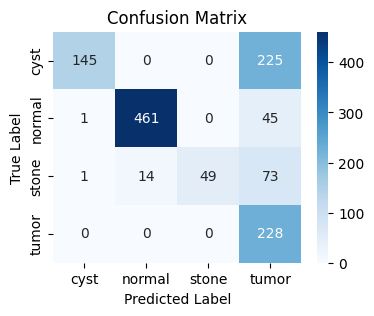

20/20 [==============================] - 2s 80ms/step


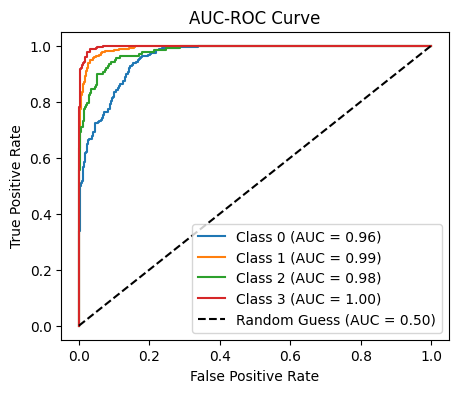

In [4]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, DenseNet201, ResNet50V2
import cv2
from tqdm import tqdm
import torch
from torchvision import transforms
from PIL import Image
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 数据集路径
dataset_dir = r'C:\Users\zhou\Desktop\dataset'
train_dir = os.path.join(dataset_dir, 'train(augmented)')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

# 标签文件路径
train_labels_path = r'C:\Users\zhou\Desktop\dataset\train.csv'
val_labels_path = r'C:\Users\zhou\Desktop\dataset\val.csv'
test_labels_path = r'C:\Users\zhou\Desktop\dataset\test.csv'

# 加载标签并更新路径
train_df = pd.read_csv(train_labels_path)
train_df['path'] = train_df['path'].apply(lambda x: os.path.join(train_dir, x))

val_df = pd.read_csv(val_labels_path)
val_df['path'] = val_df['path'].apply(lambda x: os.path.join(val_dir, x))

test_df = pd.read_csv(test_labels_path)
test_df['path'] = test_df['path'].apply(lambda x: os.path.join(test_dir, x))

# 定义超参数
batch_size = 64
epochs = 5
img_size = (224, 224)

# 数据生成器
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

# 加载训练好的模型
model_path = r'C:\Users\zhou\Desktop\dataset\Model\shufflenet.h5'
model = load_model(model_path)

# 假设 test_generator 是一个 Keras 的 ImageDataGenerator 实例，已用于生成测试数据
# 预测结果
y_pred = np.argmax(model.predict(test_generator), axis=1)

# 获取真实标签
y_true = test_generator.classes

# 输出分类报告
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(f"Classification report:\n{report}\n")

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred)

# 输出混淆矩阵
print("Confusion Matrix:")
print(conf_matrix)

# 使用 Seaborn 绘制热力图来显示混淆矩阵
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 获取预测的概率（而不是类别标签）
y_pred_prob = model.predict(test_generator)

# 将真实标签进行二值化处理，以便计算 ROC 曲线
y_true_bin = label_binarize(y_true, classes=list(test_generator.class_indices.values()))

# 计算每个类别的 ROC 曲线和 AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# 对于每一个类别，计算 FPR、TPR 和 AUC
for i in range(y_true_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制 AUC-ROC 曲线
plt.figure(figsize=(5, 4))
for i in range(y_true_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

# 绘制随机猜测的对角线（FPR = TPR）
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()
